In [1]:
from rydanalysis import AbsorptionImaging, OldStructure, ExpSequence, Gaussian2D, fit_dataarray
from rydanalysis import EllipticalMask, PolygonMask
from pathlib import Path
from lmfit import Parameter
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr


In [2]:
home = Path.home()
od = xr.load_dataarray(home/'Institut/analysis/2020_06_04/dDDSbluepro/od.h5')

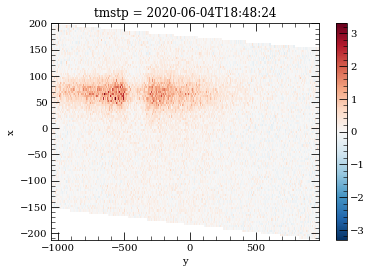

In [3]:
od[25].plot()
od = od.interpolate_na(dim='x')
od = od.fillna(0)

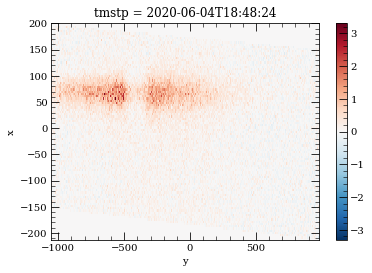

In [4]:
od[25].plot()

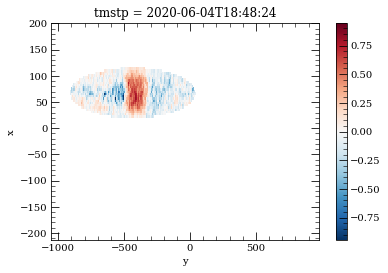

In [5]:
images = od
im = od[25]
im = im.gaussian_filter(3)
model_twolvl = Gaussian2D(prefix='twolvl_')
params_twolvl = model_twolvl.guess(im)
result = model_twolvl.fit(im, params=params_twolvl)
params_twolvl = result.params
im_masked = im.eit_mask.apply_mask(center_x = params_twolvl['twolvl_cen_x'],
                       center_y = params_twolvl['twolvl_cen_y'],
                       width_x = params_twolvl['twolvl_sig_x']*3,
                       width_y = params_twolvl['twolvl_sig_y']*3,
                       width_eit = params_twolvl['twolvl_sig_x']*3)


result = model_twolvl.fit(im, params=params_twolvl)
params_twolvl = result.params

residual = im-result.eval()
residual = residual.elliptical_mask.apply_mask(
    center_x = params_twolvl['twolvl_cen_x'],
                   center_y = params_twolvl['twolvl_cen_y'],
                       width_x = params_twolvl['twolvl_sig_x']*2,
                       width_y = params_twolvl['twolvl_sig_y']*1,)
(-residual).plot()

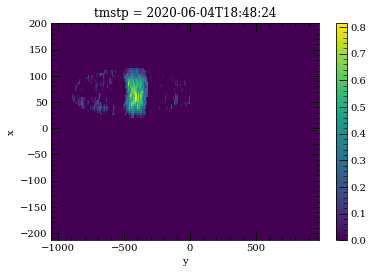

In [6]:
residual_no_na = -residual
residual_no_na = residual_no_na - residual_no_na.where(residual_no_na<0).fillna(0)
residual_no_na = residual_no_na.fillna(0)
residual_no_na.plot()

In [7]:
model_dip = Gaussian2D(prefix='eit_')
params_dip = model_dip.guess(residual_no_na, use_quantile=True)
#params_dip['eit_amp'].value = residual_no_na.quantile(0.1).data
#params_dip['eit_offset'].value= residual.quantile(0.9).data

In [8]:
params_dip

name,value,initial value,min,max,vary
eit_amp,0.00000000,None,-inf,inf,True
eit_cen_x,65.1280894,None,-inf,inf,True
eit_cen_y,-433.254370,None,-inf,inf,True
eit_sig_x,189.859149,None,0.00000000,inf,True
eit_sig_y,91.2189913,None,0.00000000,inf,True
eit_offset,0.00000000,None,-inf,inf,True
eit_theta,-0.01145702,None,-0.79685519,0.77394114,True


(<Figure size 432x432 with 4 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

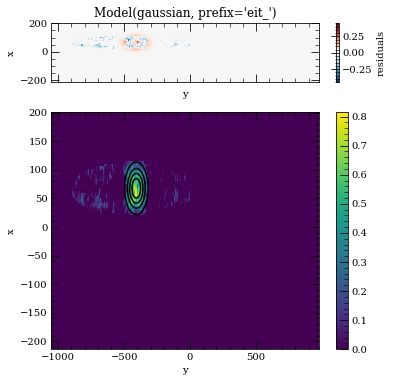

In [9]:
result = model_dip.fit(residual_no_na, params=params_dip)
result.plot()

In [10]:
params_dip

name,value,initial value,min,max,vary
eit_amp,0.00000000,None,-inf,inf,True
eit_cen_x,65.1280894,None,-inf,inf,True
eit_cen_y,-433.254370,None,-inf,inf,True
eit_sig_x,189.859149,None,0.00000000,inf,True
eit_sig_y,91.2189913,None,0.00000000,inf,True
eit_offset,0.00000000,None,-inf,inf,True
eit_theta,-0.01145702,None,-0.79685519,0.77394114,True


In [11]:
params_twolvl

name,value,standard error,relative error,initial value,min,max,vary
twolvl_amp,1.14380480,0.00333941,(0.29%),1.1437945888581533,-inf,inf,True
twolvl_cen_x,67.5177217,0.06754140,(0.10%),67.51763398147196,-inf,inf,True
twolvl_cen_y,-435.738478,1.54325252,(0.35%),-435.7364173102717,-inf,inf,True
twolvl_sig_x,23.3969418,0.07015399,(0.30%),23.397279624814733,0.00000000,inf,True
twolvl_sig_y,472.403617,1.76480343,(0.37%),472.40699822513363,0.00000000,inf,True
twolvl_offset,0.03603331,5.3350e-04,(1.48%),0.036032323525829836,-inf,inf,True
twolvl_theta,-0.00328504,2.1776e-04,(6.63%),-0.0032850987786701147,-0.76538857,0.80540776,True


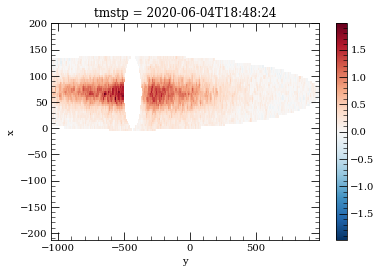

In [12]:

model = model_twolvl + model_dip
params = params_twolvl + params_dip

In [14]:
model = model_twolvl + model_dip
params = params_twolvl + params_dip

(<Figure size 432x432 with 4 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

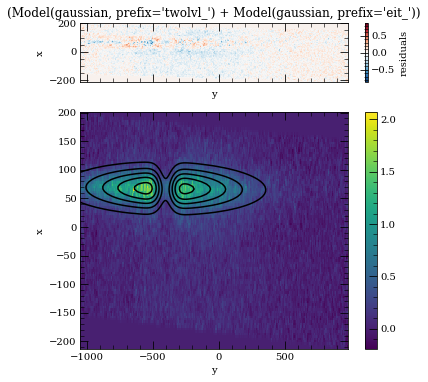

In [16]:
fit_result = model.fit(im, params)
# use results as new initial values
params = fit_result.params
fit_result.plot()